In [ ]:
library(dagitty)
library(lavaan)


We'll work with one of Pearl's SCM examples meant to represent the salary of a person as an effect of both her years of schooling and years in the profession.
So, the SCM contains $X$ being *years of schooling*, $Y$ *years in the profession*, $Z$ *salary*, and the function $$f_Z : Z = 3X + 2Y$$

Let's first generate a causal graph that matches the SCM above:

In [2]:
g <- dagitty('dag {
             X [pos="0,0"]
             Y [pos="0,2"]
             Z [pos="1,1"]
  X -> Z
  Y -> Z
}')


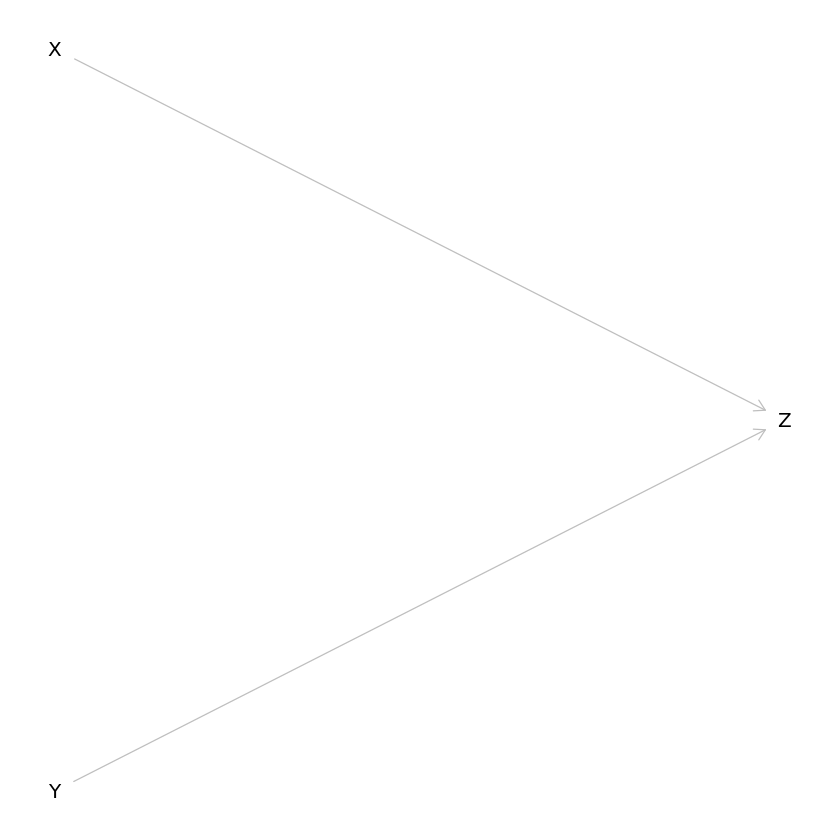

In [3]:
plot(g)


Now we'll use the `lavaan` library and its syntax to implement the SCM in R:

In [4]:
lavaan_model <- "Z ~ 3*X + 2*Y"


In order to illustrate how Pearl's ideas may work wil real-world datasets, we will artificially generate a small data set of 10 observations from this SCM plus some random noise:

In [5]:
# Set the pseudorandom number generator seed, makes this script's outcomes the same always
set.seed(12345)
g_tbl <- simulateData(lavaan_model, sample.nobs = 10)


In [6]:
g_tbl


Z,X,Y
<dbl>,<dbl>,<dbl>
2.2410623,0.3736241,0.10937027
2.7485590,-0.7400342,1.69078114
-0.4506860,-0.1593232,0.33922380
-1.7972664,-0.3301132,0.40514688
2.1631033,1.2374138,-0.07708463
-6.6841226,-2.2937990,-0.54740791
2.3260337,1.0996164,-0.33219156
-0.9930119,-0.1678624,-0.51041491
-1.0233848,-0.9781515,0.69482796


And now, to get even closer to a real-world situation, we'll fit the SCM defined above *without the coefficients* to the artificially generated data set using a traditional structured equations model (SEM).
This situation may occur whenever we have a causal graph that represents a plausible (causal) hypothesis given our background knowledge, but when we do not have a specific SCM compatible with our graph:

In [7]:
lavaan_model_no_coefs <- "Z ~ X + Y"
lavaan_fit <- sem(lavaan_model_no_coefs, data = g_tbl)


Even though our data set only has 10 observations, the estimation has correct confidence intervals that capture the original SCM coefficients (3 for $X$, 2 for $Y$):

In [8]:
parameterEstimates(lavaan_fit)


lhs,op,rhs,est,se,z,pvalue,ci.lower,ci.upper
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Z,~,X,2.46867205,0.2776809,8.890320,0.000000e+00,1.92442751,3.01291658
Z,~,Y,2.29442526,0.4276380,5.365344,8.079505e-08,1.45627009,3.13258042
Z,~~,Z,0.74721956,0.3341667,2.236068,2.534732e-02,0.09226477,1.40217435
X,~~,X,0.97680316,0.0000000,NA,NA,0.97680316,0.97680316
X,~~,Y,-0.05642633,0.0000000,NA,NA,-0.05642633,-0.05642633
Y,~~,Y,0.41185691,0.0000000,NA,NA,0.41185691,0.41185691


In parallel to this, we can also fit a linear model with `lm()` to Z and X alone, using the data generated above:

In [9]:
lm(Z ~ X, data = g_tbl)



Call:
lm(formula = Z ~ X, data = g_tbl)

Coefficients:
(Intercept)            X  
     0.1694       2.3361  


For the simple collider model $X → Z ← Y$, by the rules of Pearl's d-separation we know that $X$ and $Y$ are unconditionally independent, and that conditioning on $Z$ renders them dependent.
That is, for all possible values $x,y$ that $X,Y$ can assume correspondingly:
$$P(X = x | Y = y) = P(X = x)$$
*except* whenever we condition on $Z$.

Conveniently, dagitty's `impliedConditionalIndependencies()` will give us all of the conditional independencies implied by a graph using precisely Pearl's d-separation rules.
Unsurprisingly, the conclusion is the same ($X$ and $Y$ are independent):

In [10]:
impliedConditionalIndependencies(g)


X _||_ Y

This implication of a causal model can be tested against regressions on empirical data sets, recalling that the independence of two variables implies that their regression equals $0$:

In [11]:
lm(Y ~ X, data = g_tbl)



Call:
lm(formula = Y ~ X, data = g_tbl)

Coefficients:
(Intercept)            X  
    0.13861     -0.05777  


As this data by design does not match exactly the original SCM, the regression outputs a non-zero value.
It is close to zero though, a situation that changes when we condition on $Z$, rendering both variables clearly dependent:

In [12]:
lm(Y ~ X + Z, data = g_tbl)



Call:
lm(formula = Y ~ X + Z, data = g_tbl)

Coefficients:
(Intercept)            X            Z  
    0.08381     -0.81344      0.32347  


So the situation is the following:
in our causal graph we do not have a link between $X$ and $Y$;
however, our (artificially generated, with some random noise) data set implies that $X$ and $Y$ are not strictly independent (as their regression is nonzero), meaning that a causal graph representing them should include a link between $X$ and $Y$.
However, note that the confidence intervals estimated above actually include the coefficients of the original SCM, meaning that this mismatch is not enough to reject our original causal model as the correct representation of the data set.

Let's now see what happens with more (artificial) observations.
This time we'll repeat the whole process with a bigger (artificial) data set containing 1000 observations:

In [13]:
g_tbl_big <- simulateData(lavaan_model, sample.nobs = 1000)
lavaan_fit_big <- sem(lavaan_model_no_coefs, data = g_tbl_big)
parameterEstimates(lavaan_fit_big)


lhs,op,rhs,est,se,z,pvalue,ci.lower,ci.upper
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Z,~,X,3.006043019,0.03051025,98.52566,0,2.946244019,3.065842020
Z,~,Y,2.003098683,0.02928910,68.39058,0,1.945693097,2.060504269
Z,~~,Z,0.904099344,0.04043255,22.36068,0,0.824852998,0.983345689
X,~~,X,0.971248305,0.00000000,NA,NA,0.971248305,0.971248305
X,~~,Y,0.003692934,0.00000000,NA,NA,0.003692934,0.003692934
Y,~~,Y,1.053925253,0.00000000,NA,NA,1.053925253,1.053925253


Now the parameters estimated are much closer to those of the original SCM, and the confidence intervals are much narrower.
This of course has implications for the regression of $Y$ on $X$, where the coefficient estimated is much smaller (but still nonzero):

In [14]:
lm(Y ~ X, data = g_tbl_big)



Call:
lm(formula = Y ~ X, data = g_tbl_big)

Coefficients:
(Intercept)            X  
   0.004493     0.003802  
